In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [8]:

#  Step 1: data editing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=1),  
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),      # Augmentation
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# Step 2️: Load dataset from folders
data_dir = r"C:\Users\Rose\Documents\mcmaster\semester 2\cps\part1-deep learning\project cps\archive (6)\chest_xray" 

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

# Step 3️: Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training images: {len(train_dataset)}, Testing images: {len(test_dataset)}, Validation images: {len(val_dataset)}")


Training images: 5216, Testing images: 624, Validation images: 16


In [9]:
class TeacherCNN(nn.Module):
    def __init__(self):  
        super(TeacherCNN, self).__init__()  # Inherit from nn.Module
        
        # Convolutional Layers (More layers than Student Model)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers with Two Dropouts
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Increased neurons
        self.dropout1 = nn.Dropout(0.3)  # First Dropout (before 2nd FC layer)
        self.fc2 = nn.Linear(512, 256)  # New FC layer
        self.dropout2 = nn.Dropout(0.2)  # Second Dropout (before final FC layer)
        self.fc3 = nn.Linear(256, 1)  # Final output layer (binary classification)

    def forward(self, x):  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))  # First FC layer
        x = self.dropout1(x)  # Apply first dropout
        x = F.relu(self.fc2(x))  # Second FC layer
        x = self.dropout2(x)  # Apply second dropout
        x = self.fc3(x)  # Output layer (logits)
        return x
        
# Step 2️: Initialize the Teacher Model
teacher_model = TeacherCNN()

# Step 3️: The Model Architecture
print(teacher_model)

TeacherCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# Step 1️: Move Model to GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

# Step 2️: Define Optimizer and Loss Function
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)  # Adam optimizer

# Step 3️: Load Data into DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 4️: Train the Model
num_epochs = 5  
for epoch in range(num_epochs):
    teacher_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Move to GPU if available for Mohmmad

        optimizer.zero_grad()  # Reset gradients
        outputs = teacher_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Step 5️: Save the Trained Teacher Model
torch.save(teacher_model.state_dict(), "teacher_model.pth")
print("Teacher Model Trained and Saved!")

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Initialize the Teacher Model
teacher_model = TeacherCNN().to(device)  # Ensure the model is on the correct device

#  Load the trained weights
teacher_model.load_state_dict(torch.load("teacher_model.pth", map_location=device, weights_only=True))

#  Set the Teacher Model to Evaluation Mode (Important for Distillation)
teacher_model.eval()

print(" Teacher Model Loaded Successfully!")


✅ Teacher Model Loaded Successfully!


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StudentCNN(nn.Module):
    def __init__(self, input_height=224, input_width=224):
        super(StudentCNN, self).__init__()
        
        #  Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolution + pooling
        self.flattened_size = (input_height // 4) * (input_width // 4) * 64  

        #  Fully Connected Layers
        self.fc1 = nn.Linear(self.flattened_size, 512)  
        self.dropout1 = nn.Dropout(0.3)  
        self.fc2 = nn.Linear(512, 256)  
        self.dropout2 = nn.Dropout(0.2)  
        self.fc3 = nn.Linear(256, 1)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)  

        x = F.relu(self.fc1(x))  
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))  
        x = self.dropout2(x)  

        x = self.fc3(x)  
        return x  


In [18]:
def knowledge_distillation_loss(student_logits, teacher_logits, true_labels, T=5, alpha=0.3):
    # Sigmoid probabilities for binary tasks
    student_probs = torch.sigmoid(student_logits / T)
    teacher_probs = torch.sigmoid(teacher_logits / T)
    
    # Distillation loss 
    distillation_loss = F.mse_loss(student_probs, teacher_probs)
    # distillation_loss = F.binary_cross_entropy(student_probs, teacher_probs)
    
    # Task loss (BCEWithLogits)
    task_loss = F.binary_cross_entropy_with_logits(student_logits, true_labels)
    
    return alpha * task_loss + (1 - alpha) * distillation_loss

In [15]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

#  Load the trained Teacher Model properly
teacher_model = TeacherCNN().to(device)
teacher_model.load_state_dict(torch.load("teacher_model.pth", map_location=device))  #  FIXED: Map to CPU if needed
teacher_model.eval()  #  Keep Teacher in evaluation mode

#  Initialize the Student Model
student_model = StudentCNN(input_height=224, input_width=224).to(device)

# Load the trained Student Model 
try:
    student_model.load_state_dict(torch.load("student_model.pth", map_location=device))  
    print("Student Model Loaded Successfully!")
except FileNotFoundError:
    print(" No pre-trained student model found. Training from scratch.")

#  Optimizer
optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    student_model.train()
    running_loss = 0.0

    #  Training Loop
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        with torch.no_grad():
            teacher_logits = teacher_model(images)  #  Get stable teacher predictions

        student_logits = student_model(images)
        loss = knowledge_distillation_loss(student_logits, teacher_logits, labels, T=5, alpha=0.3)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute Training Loss
    avg_train_loss = running_loss / len(train_loader)

    # Compute Validation Loss
    student_model.eval()  #  Switch Student Model to Evaluation Mode
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            student_logits = student_model(images)
            loss = knowledge_distillation_loss(student_logits, teacher_model(images), labels, T=5, alpha=0.3)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)  #  Compute average validation loss

    #  Print Training and Validation Loss
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#  Save the trained Student Model
torch.save(student_model.state_dict(), "student_model.pth")
print("Student Model Trained and Saved!")


 Using device: cpu


C:\Users\Rose\AppData\Local\Temp\ipykernel_7132\511457337.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("teacher_model.pth", m

 No pre-trained student model found. Training from scratch.


Epoch 1/10: 100%|██████████| 163/163 [22:29<00:00,  8.28s/it]


Epoch 1, Training Loss: 0.2656, Validation Loss: 0.2936


Epoch 2/10: 100%|██████████| 163/163 [22:29<00:00,  8.28s/it]


Epoch 2, Training Loss: 0.2460, Validation Loss: 0.2615


Epoch 3/10: 100%|██████████| 163/163 [23:47<00:00,  8.76s/it]


Epoch 3, Training Loss: 0.1949, Validation Loss: 0.2653


Epoch 4/10: 100%|██████████| 163/163 [24:47<00:00,  9.13s/it]


Epoch 4, Training Loss: 0.1175, Validation Loss: 0.2830


Epoch 5/10: 100%|██████████| 163/163 [24:43<00:00,  9.10s/it]


Epoch 5, Training Loss: 0.0882, Validation Loss: 0.3892


Epoch 6/10: 100%|██████████| 163/163 [24:36<00:00,  9.06s/it]


Epoch 6, Training Loss: 0.0739, Validation Loss: 0.1836


Epoch 7/10: 100%|██████████| 163/163 [5:37:17<00:00, 124.16s/it]    


Epoch 7, Training Loss: 0.0704, Validation Loss: 0.2188


Epoch 8/10: 100%|██████████| 163/163 [22:29<00:00,  8.28s/it]


Epoch 8, Training Loss: 0.0661, Validation Loss: 0.2295


Epoch 9/10: 100%|██████████| 163/163 [22:39<00:00,  8.34s/it]


Epoch 9, Training Loss: 0.0655, Validation Loss: 0.3278


Epoch 10/10: 100%|██████████| 163/163 [22:57<00:00,  8.45s/it]


Epoch 10, Training Loss: 0.0630, Validation Loss: 0.1703
Student Model Trained and Saved!


In [44]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Student Model
student_model = StudentCNN(input_height=224, input_width=224).to(device)

# Load the trained model
student_model.load_state_dict(torch.load(r"C:\Users\Rose\Documents\mcmaster\semester 2\cps\part1-deep learning\project cps\student_model (1).pth", map_location=device))

# Set the model to evaluation mode (important for testing)
student_model.eval()

print(f" Student Model Loaded Successfully on {device}!")


C:\Users\Rose\AppData\Local\Temp\ipykernel_22680\4100189950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(r"C:\Users\Rose\Docu

✅ Student Model Loaded Successfully on cpu!


In [46]:
import torch.nn.functional as F

student_model.eval()  

correct = 0
total = 0
running_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)  # Move to correct device
        outputs = student_model(images)

        # Use `binary_cross_entropy_with_logits()`
        loss = F.binary_cross_entropy_with_logits(outputs, labels)  
        running_loss += loss.item()

        # Convert raw logits to probabilities before thresholding
        predicted = (torch.sigmoid(outputs) > 0.5).float()  

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Student Model Evaluation - Loss: {running_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")


 Student Model Evaluation - Loss: 0.6128, Accuracy: 81.09%


In [26]:

print(os.getcwd())  

C:\Users\Rose\Downloads


In [48]:
import torch
import torch.nn.functional as F

# Switch Student Model to Evaluation Mode
student_model.eval()

y_true, y_pred_logits = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        outputs = student_model(images)  #  Get raw logits
        y_true.extend(labels.cpu().numpy())  #  Store true labels
        y_pred_logits.extend(outputs.cpu().numpy())  #  Store raw logits

print("✅ Collected true labels and predictions!")


✅ Collected true labels and predictions!


In [50]:
from sklearn.metrics import classification_report

# Generate predictions
with torch.no_grad():
    y_true, y_pred = [], []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


              precision    recall  f1-score   support

      Normal       0.83      0.59      0.69       234
   Pneumonia       0.79      0.93      0.85       390

    accuracy                           0.80       624
   macro avg       0.81      0.76      0.77       624
weighted avg       0.81      0.80      0.79       624



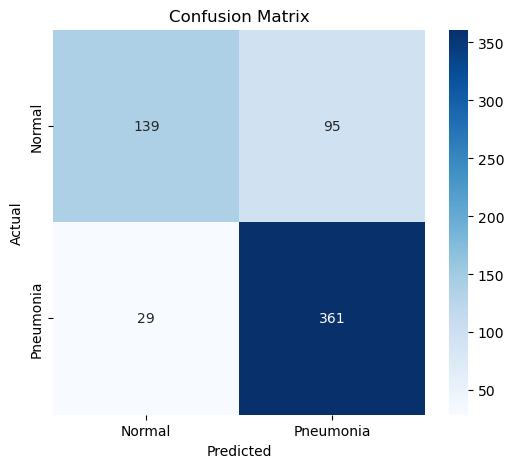

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


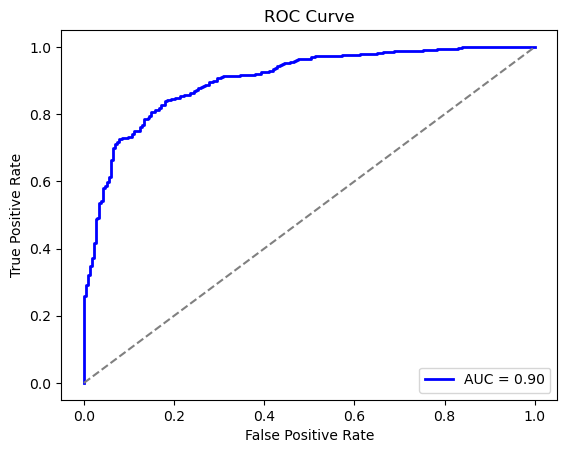

AUC Score: 0.9036


In [79]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

#  Convert logits to probabilities
y_probs = torch.sigmoid(torch.tensor(y_pred_logits)).numpy()  # ✅ Apply Sigmoid to logits

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig('ROC Curve.png')

plt.show()

print(f"AUC Score: {roc_auc:.4f}")


In [56]:
import time

# Measure inference time on a single image
sample_image = torch.randn(1, 1, 224, 224).to(device)  # Dummy X-ray image
student_model.eval()

start_time = time.time()
_ = student_model(sample_image)
inference_time = time.time() - start_time

print(f" Student Model Inference Time: {inference_time:.6f} seconds")


✅ Student Model Inference Time: 0.063485 seconds


In [58]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

#  Compute Precision, Recall, F1-score (single value)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

#  Compute AUC (single value)
auc = roc_auc_score(y_true, y_probs)  # Use predicted probabilities

#  Print results in a clean format
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Test Accuracy: 81.09%
Precision: 0.7917
Recall: 0.9256
F1-score: 0.8534
AUC: 0.9036


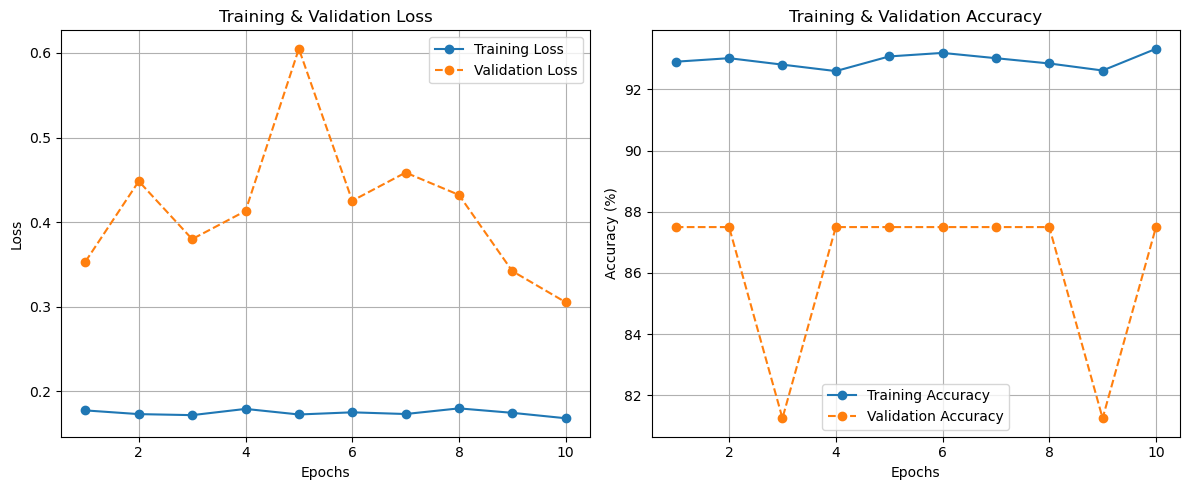

In [81]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Lists to store actual training and validation loss/accuracy
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

num_epochs = 10  # Adjust based on your training

# Loop through epochs (use actual stored logs if available)
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    # Training Phase
    student_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = student_model(images)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)

        train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation Phase
    student_model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = student_model(images)
            loss = F.binary_cross_entropy_with_logits(outputs, labels)

            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Store values in lists
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

#  Generate Training & Validation Curves
plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, marker="o", linestyle="-", label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_history, marker="o", linestyle="--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig('Training & Validation Loss')
# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_history, marker="o", linestyle="-", label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc_history, marker="o", linestyle="--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.savefig('Training & Validation Accuracy')

plt.show()
